# DenseNet121 Model - EDP

### Author - Shaurya Singh Srinet and Charvi Jain

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os, gdown, cv2, shutil, math
from glob import glob
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from keras.layers import *
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix

C:\Users\Charvi Jain\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Reading input data

In [2]:
input_directory = r"C:\Users\Charvi Jain\Downloads\dataset"

for dirname, _, filenames in os.walk(input_directory):
        print("Dataset Accessed from Local Machine")


Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine
Dataset Accessed from Local Machine


### Data Distribution Graph

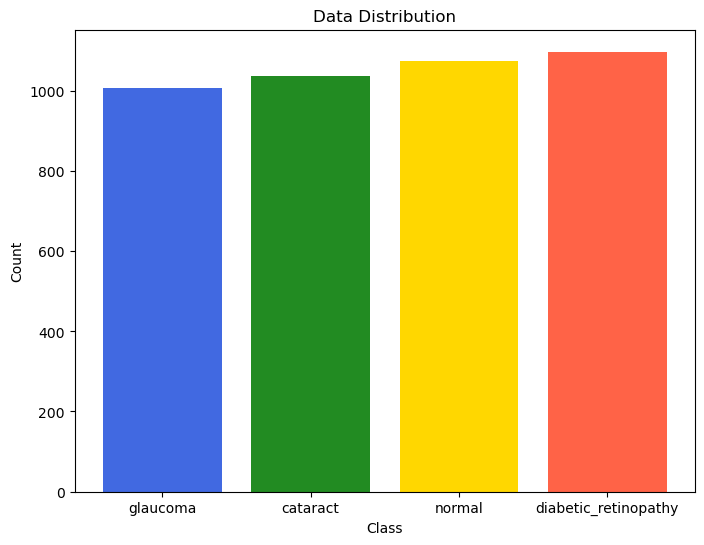

In [1]:
import matplotlib.pyplot as plt
class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"]
# Count for each class
count_for_class_0 = 1007
count_for_class_1 = 1038
count_for_class_2 = 1074
count_for_class_3 = 1098

# Creating a list with the counts
class_counts = [count_for_class_0, count_for_class_1, count_for_class_2, count_for_class_3]

# Defining colors for the bar graph
colors = ['royalblue', 'forestgreen', 'gold', 'tomato']

# Creating a bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=colors)

# Adding labels and a title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Data Distribution")

plt.show()


### Making Dataframes

In [4]:
sdir = r"C:\Users\Charvi Jain\Downloads\dataset"


def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          ' the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df


train_df, test_df, valid_df = make_dataframes(sdir=sdir)

normal                 : 100%|█████████████████████████████████████████| 1074/1074 [00:06<00:00, 178.76file/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  878  the minimum files in any class in train_df is  806
train_df length:  3373   test_df length:  422   valid_df length:  422
average image height=  502   average image width=  536  aspect ratio h/w=  0.9365671641791045


### Creating Data using ImageGenerator

In [5]:
batch_size = 64
img_height, img_width = 300, 300
img_size = (img_height, img_width)
input_shape = (img_height, img_width, 3)

def create_data(batch_size, train_df, test_df, valid_df, img_size):
    train_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=20, vertical_flip=True, shear_range=0.2, dtype=float)
    test_gen = ImageDataGenerator(rescale=1/255.0, dtype=float)
    
    train_set = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    test_set = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    val_set = test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    
    return train_set, test_set, val_set


train_set, test_set, val_set = create_data(batch_size, train_df, test_df, valid_df, img_size)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


### Label Mapping

In [6]:
label_dict = {v:k for k,v in train_set.class_indices.items()}
label_dict

{0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}

### Initializing model generating and callback function

In [7]:
def generate_model(pretrained_base,name=None):

    pretrained_base.trainable=False
    model = Sequential([
        pretrained_base,
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=4, activation='softmax')
    ], name=name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', F1Score(num_classes=4)])
    
    return model

In [11]:
def generate_callbacks(DenseNet121):
    checkpoint = ModelCheckpoint(filepath=f'DenseNet121.h5', save_best_only=True, save_weights_only=True)
    return [checkpoint]


### Configuring a DenseNet121 model

In [12]:
import tensorflow as tf
pretrained_params = {
    'weights':'imagenet',
    'include_top':False,
    'input_shape':input_shape
}


pretrained_models = {
    'DenseNet121':tf.keras.applications.DenseNet121(**pretrained_params)
}


fit_args = {
    'epochs':10,
    'steps_per_epoch':train_set.n//train_set.batch_size,
    'validation_data':val_set,
    'validation_steps':val_set.n//val_set.batch_size
}

In [13]:
DenseNet121_model = generate_model(pretrained_models['DenseNet121'], name='DenseNet121')
callbacks = generate_callbacks('DenseNet121')
history = DenseNet121_model.fit(train_set, callbacks=callbacks, **fit_args)
DenseNet121_model.save('DenseNet121.h5')

Epoch 1/10
52/52 [==============================] - 535s 10s/step - loss: 3.7027 - categorical_accuracy: 0.5966 - f1_score: 0.5961 - val_loss: 0.3844 - val_categorical_accuracy: 0.8568 - val_f1_score: 0.8569
Epoch 2/10
52/52 [==============================] - 602s 12s/step - loss: 0.7426 - categorical_accuracy: 0.7903 - f1_score: 0.7876 - val_loss: 0.4926 - val_categorical_accuracy: 0.8464 - val_f1_score: 0.8431
Epoch 3/10
52/52 [==============================] - 696s 13s/step - loss: 0.3923 - categorical_accuracy: 0.8694 - f1_score: 0.8676 - val_loss: 0.3937 - val_categorical_accuracy: 0.8672 - val_f1_score: 0.8533
Epoch 4/10
52/52 [==============================] - 1088s 21s/step - loss: 0.3843 - categorical_accuracy: 0.8701 - f1_score: 0.8679 - val_loss: 0.2290 - val_categorical_accuracy: 0.9115 - val_f1_score: 0.9078
Epoch 5/10
52/52 [==============================] - 1528s 29s/step - loss: 0.2954 - categorical_accuracy: 0.8994 - f1_score: 0.8973 - val_loss: 0.3588 - val_categorica

C:\Users\Charvi Jain\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
densenet = load_model('DenseNet121.h5')

In [15]:
inputs = Input(shape=input_shape)
densenet_preds = densenet(inputs)

In [16]:
# Averaging for DenseNet predictions
outputs= densenet_preds 

### Plotting training & validation accuracy and loss values

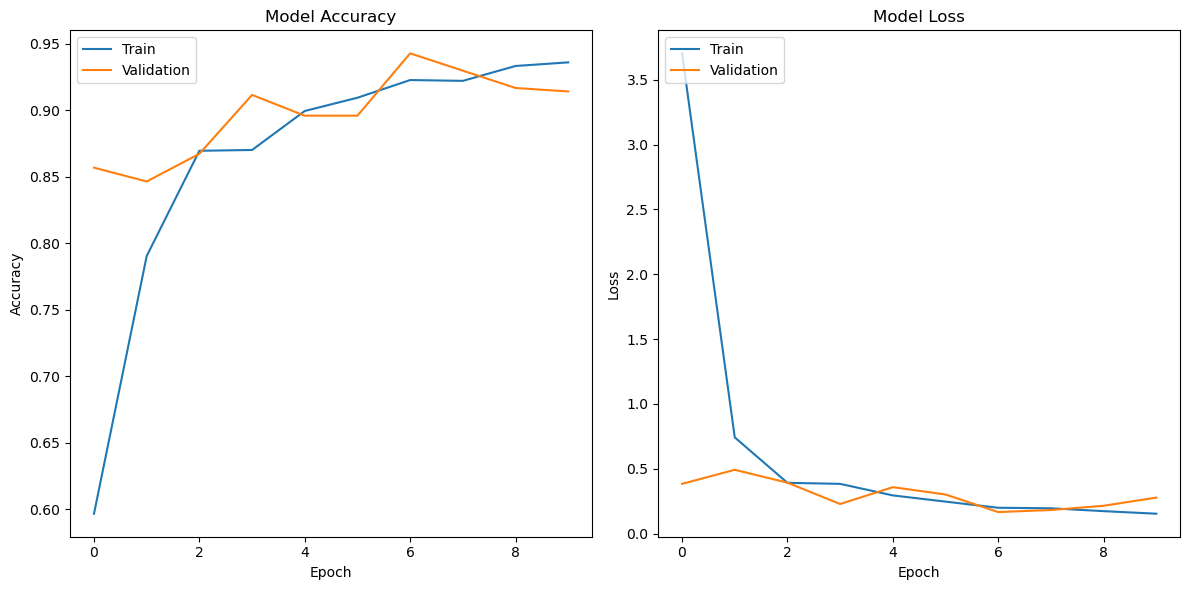

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Generating confusion matrix and classification report

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on the test set
test_predictions = DenseNet121_model.predict(test_set)

# Convert predictions to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)

# Use the original labels from the generator
test_true_labels = test_set.labels

# If the true labels are not one-hot encoded, convert them
if isinstance(test_true_labels[0], list):
    test_true_labels = np.argmax(test_true_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true_labels, test_pred_labels, target_names=class_names)
print("\nClassification Report:")
print(class_report)


7/7 [==============================] - 45s 6s/step
Confusion Matrix:
[[25 26 25 28]
 [25 34 23 28]
 [30 24 20 27]
 [24 28 28 27]]

Classification Report:
                      precision    recall  f1-score   support

            glaucoma       0.24      0.24      0.24       104
            cataract       0.30      0.31      0.31       110
              normal       0.21      0.20      0.20       101
diabetic_retinopathy       0.25      0.25      0.25       107

            accuracy                           0.25       422
           macro avg       0.25      0.25      0.25       422
        weighted avg       0.25      0.25      0.25       422

